In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
import pickle

/Users/gimli/projects/igre


In [2]:
with open("data/processed/metacentrum/43-pickled.pkl", "rb") as src:
    data = pickle.load(src)

In [3]:
import pandas as pd
df = pd.DataFrame(data)
df.columns = ["x_shift", "y_shift", "rotation", "x_scale", "y_scale", 
              "distance", "sample", "repeat", 
              "x_est", "y_est", "rot_est", "x_sc_est", "y_sc_est"]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df["shift_err"] = np.sqrt(
    np.power(df["x_shift"]-df["x_est"], 2) 
    + np.power(df["y_shift"]-df["y_est"], 2) 
)
df["rot_err"] = 400 * np.sqrt(2) * np.sin(np.abs(df["rotation"] - df["rot_est"]) / 2 / 180 * np.pi) * 2
df["scale_err"] = np.sqrt(
    np.power(400 * (df["x_scale"] - 1 / df["x_sc_est"]), 2) +
    np.power(400 * (df["y_scale"] - 1 / df["y_sc_est"]), 2)
)

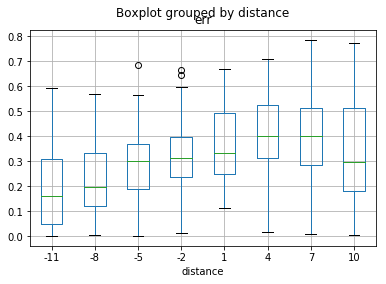

In [75]:
(df[df["err"] < 1][["sample", "distance", "err"]] \
             .groupby(["sample", "distance"]).agg("count")/ \
df[["sample", "distance", "err"]] \
             .groupby(["sample", "distance"]).agg("count")).boxplot(by="distance", column="err")
            

In [74]:
df["err"] =  df["rot_err"] + df["scale_err"]

In [7]:
correct = df[df["err"]<1].groupby(["sample", "distance"])["err"].agg(["count"]).unstack(fill_value=0).stack()
processed = df.groupby([ "sample", "distance"])["err"].agg(["count"])
to_show = correct.div(processed)

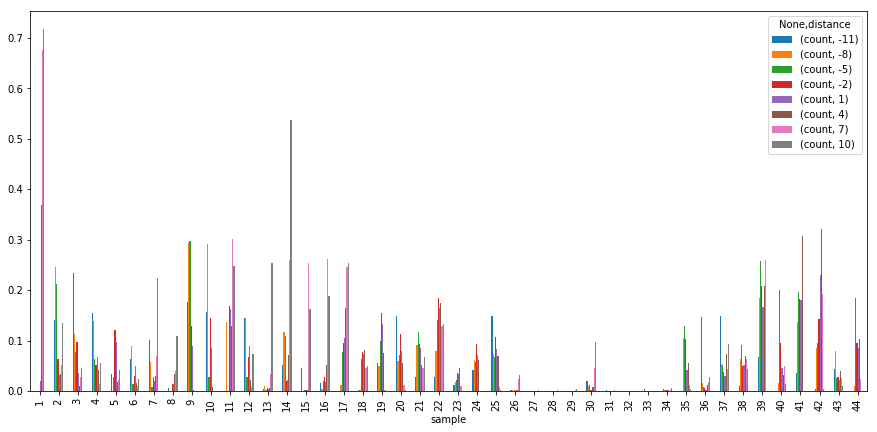

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
to_show.unstack().plot.bar(ax=ax)
plt.show()

In [9]:
# clustering podle vstupního displacementu
df["lt_displacement"] = np.sqrt(np.power(df["x_shift"], 2) + np.power(df["y_shift"], 2))
x_real = df["x_scale"] * np.cos(df["rotation"]/180*np.pi) * 400 - np.sin(df["rotation"]/180*np.pi) * 400 + df["x_shift"]
y_real = df["y_scale"] * np.cos(df["rotation"]/180*np.pi) * 400 + np.sin(df["rotation"]/180*np.pi) * 400 + df["y_shift"]
df["rb_displacement"] = np.sqrt(np.power(400-x_real, 2) + np.power(400-y_real, 2))

In [10]:
df["lt_out_displacement"] = np.sqrt(np.power(df["x_shift"]-df["x_est"], 2) + np.power(df["y_shift"]-df["y_est"], 2))
x_real_out = (1 - np.abs(df["x_scale"] - 1 / df["x_sc_est"])) * np.cos((df["rotation"] - df["rot_est"]) / 180 * np.pi) * 400 \
            - np.sin((df["rotation"]-df["rot_est"]) / 180 * np.pi) * 400 
            #+ df["x_shift"] - df["x_est"]
y_real_out = (1 - np.abs(df["y_scale"] - 1 / df["y_sc_est"])) * np.cos((df["rotation"] - df["rot_est"]) / 180 * np.pi) * 400 \
            + np.sin((df["rotation"] - df["rot_est"]) / 180 * np.pi) * 400
            #+ df["y_shift"] - df["y_est"]
df["rb_out_displacement"] = np.sqrt(np.power(400 - x_real_out, 2) + np.power(400 - y_real_out, 2))

In [11]:
df["err"] = df[["lt_out_displacement", "rb_out_displacement"]].max(axis=1)

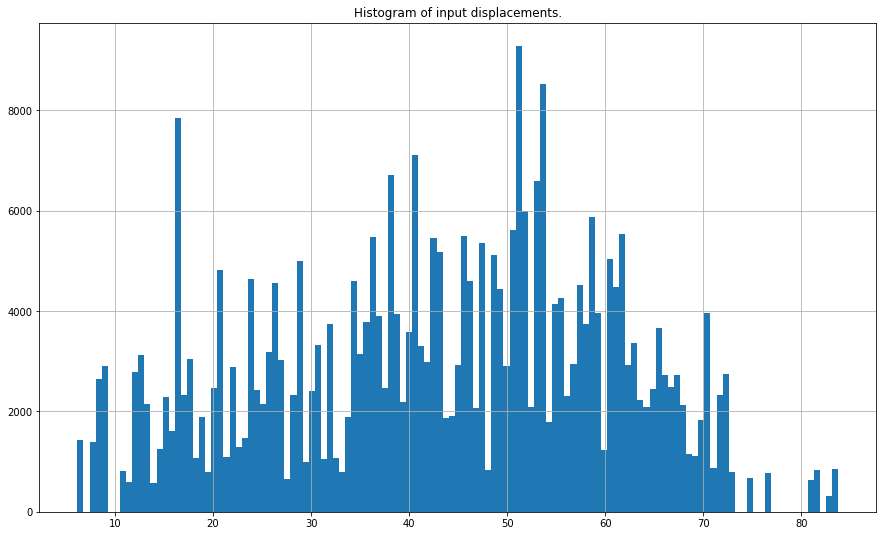

In [12]:
fig, ax = plt.subplots(figsize=(15,9))
df[["rb_displacement", "lt_displacement"]].max(axis=1).hist(ax=ax, bins=125)
plt.title("Histogram of input displacements.")
plt.show()

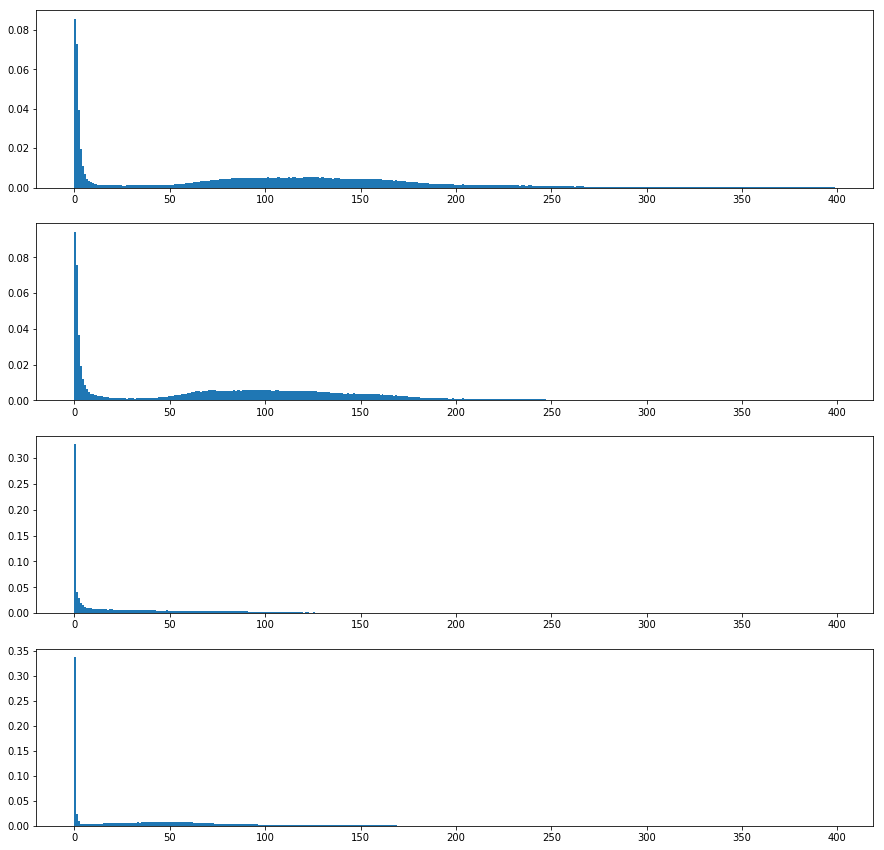

In [13]:
plt.figure(figsize=(15,15))
ax = plt.subplot(4,1,1)
ax.hist(df["err"], bins=np.arange(0,400,1), weights=np.ones(len(df["err"]))/len(df["err"]))
ax = plt.subplot(4,1,2)
ax.hist(df["shift_err"], bins=np.arange(0,400,1), weights=np.ones(len(df["err"]))/len(df["err"]))
ax = plt.subplot(4,1,3)
ax.hist(df["rot_err"], bins=np.arange(0,400,1), weights=np.ones(len(df["err"]))/len(df["err"]))
ax = plt.subplot(4,1,4)
ax.hist(df["scale_err"], bins=np.arange(0,400,1), weights=np.ones(len(df["err"]))/len(df["err"]))
plt.show()

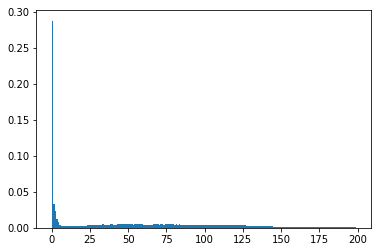

In [14]:
plt.hist(df["rb_out_displacement"], bins=np.arange(0,200,1), weights=np.ones(len(df["rb_out_displacement"]))/len(df["rb_out_displacement"]))
plt.show()

/usr/local/lib/python3.7/site-packages/pandas/plotting/_core.py:2254: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  return_type=return_type, **kwds)


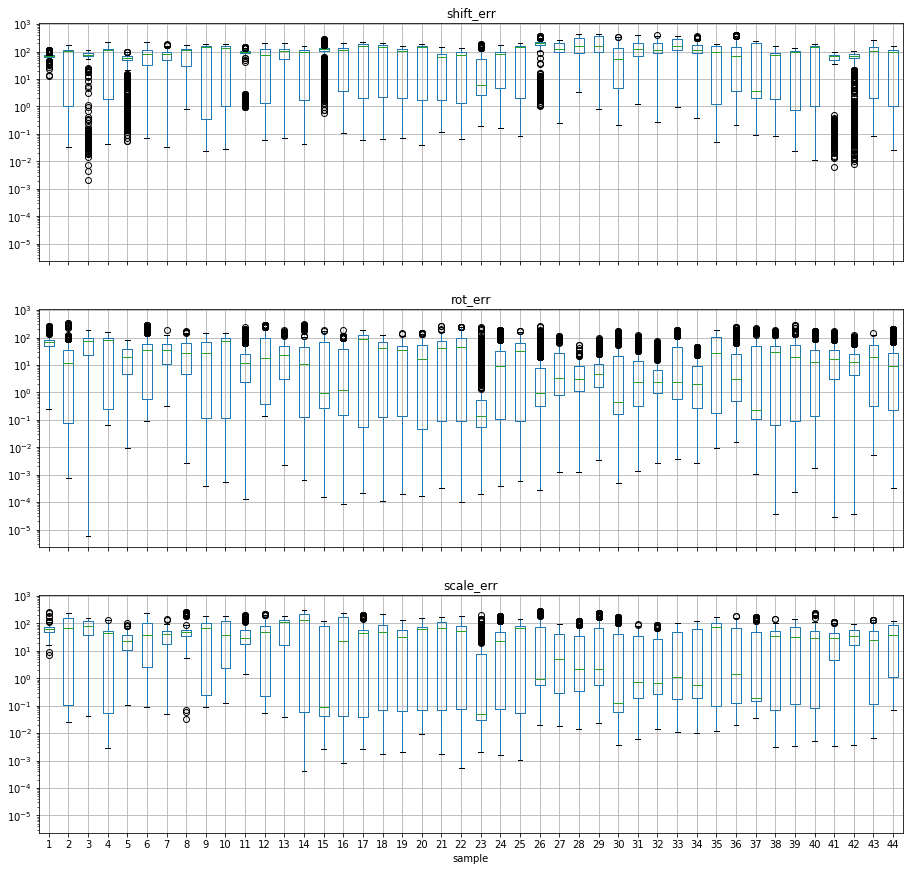

In [15]:
fig, ax = plt.subplots(figsize=(15,15))
df[df["distance"]==-5].boxplot(
    by="sample", 
    column=["shift_err", "rot_err", "scale_err"], 
    ax=ax,
    layout=(3,1)
)
plt.suptitle("")
#plt.title("""Registration error in pixels""", fontsize=20)
plt.yscale("log")
plt.savefig("reports/figures/reg_err_42.pdf")
plt.show()

In [16]:
success_ratio_001 = np.zeros((44, len(set(df["distance"]))))
success_ratio_01 = np.zeros((44, len(set(df["distance"]))))
success_ratio_05 = np.zeros((44, len(set(df["distance"]))))
success_ratio_1 = np.zeros((44, len(set(df["distance"]))))
for smp in range(1,45):
    for idx, dist in enumerate(set(df["distance"])):
        success_ratio_001[smp-1, idx] = len(df[df["distance"]==dist][df["sample"]==smp][df["rb_out_displacement"]<0.01])/len(df[df["distance"]==dist][df["sample"]==smp])
        success_ratio_01[smp-1, idx] = len(df[df["distance"]==dist][df["sample"]==smp][df["rb_out_displacement"]<0.1])/len(df[df["distance"]==dist][df["sample"]==smp])
        success_ratio_05[smp-1, idx] = len(df[df["distance"]==dist][df["sample"]==smp][df["rb_out_displacement"]<0.5])/len(df[df["distance"]==dist][df["sample"]==smp])
        success_ratio_1[smp-1, idx] = len(df[df["distance"]==dist][df["sample"]==smp][df["rb_out_displacement"]<1])/len(df[df["distance"]==dist][df["sample"]==smp])        

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


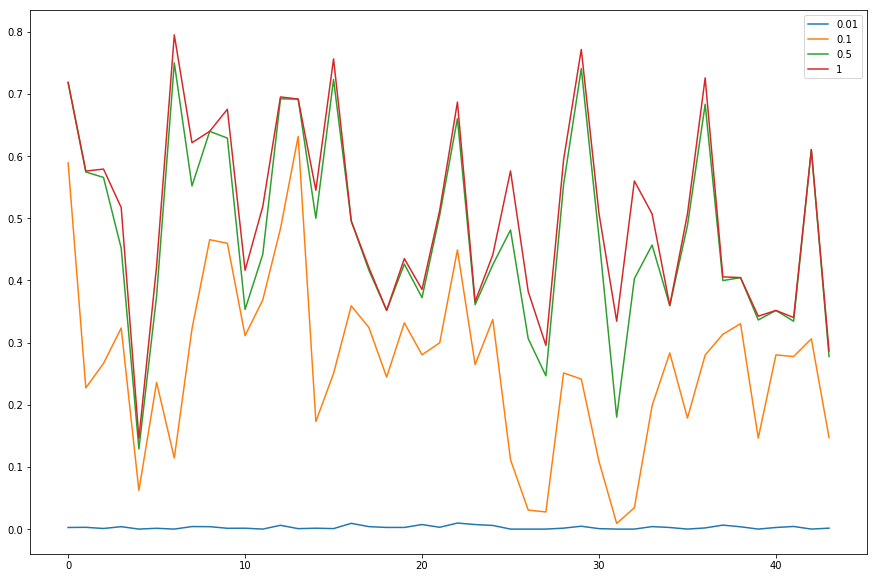

In [17]:
plt.figure(figsize=(15,10))
plt.plot(np.max(success_ratio_001, axis=1), label="0.01")
plt.plot(np.max(success_ratio_01, axis=1), label="0.1")
plt.plot(np.max(success_ratio_05, axis=1), label="0.5")
plt.plot(np.max(success_ratio_1, axis=1), label="1")
plt.legend()
plt.show()

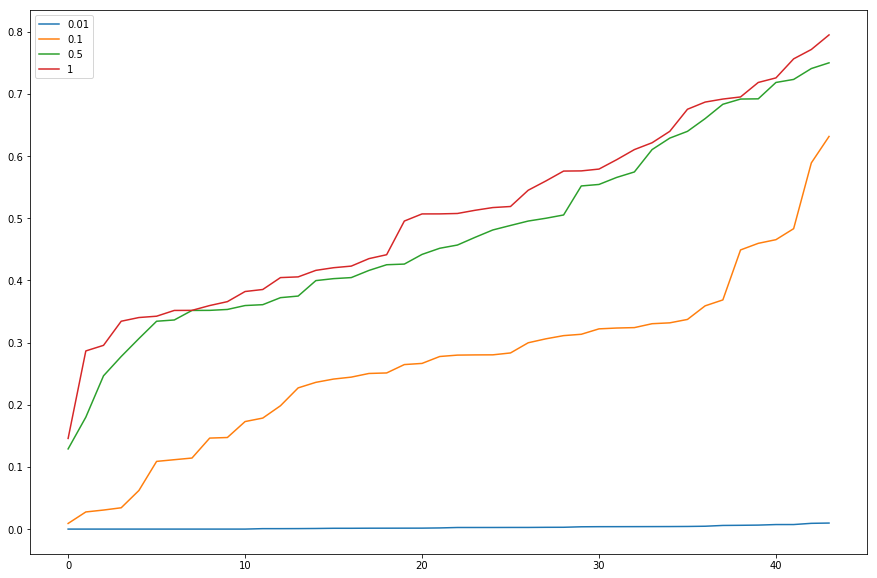

In [18]:
plt.figure(figsize=(15,10))
plt.plot(sorted(np.max(success_ratio_001, axis=1)), label="0.01")
plt.plot(sorted(np.max(success_ratio_01, axis=1)), label="0.1")
plt.plot(sorted(np.max(success_ratio_05, axis=1)), label="0.5")
plt.plot(sorted(np.max(success_ratio_1, axis=1)), label="1")
plt.legend()
plt.show()

In [19]:
# clustering podle realného displacementu
df["lt_in_displacement"] = np.sqrt(np.power(df["x_shift"], 2) + np.power(df["y_shift"], 2))
x_real = df["x_scale"] * np.cos(df["rotation"]/180*np.pi) * 400 - np.sin(df["rotation"]/180*np.pi) * 400 + df["x_shift"]
y_real = df["y_scale"] * np.cos(df["rotation"]/180*np.pi) * 400 + np.sin(df["rotation"]/180*np.pi) * 400 + df["y_shift"]
df["rb_in_displacement"] = np.sqrt(np.power(400-x_real, 2) + np.power(400-y_real, 2))

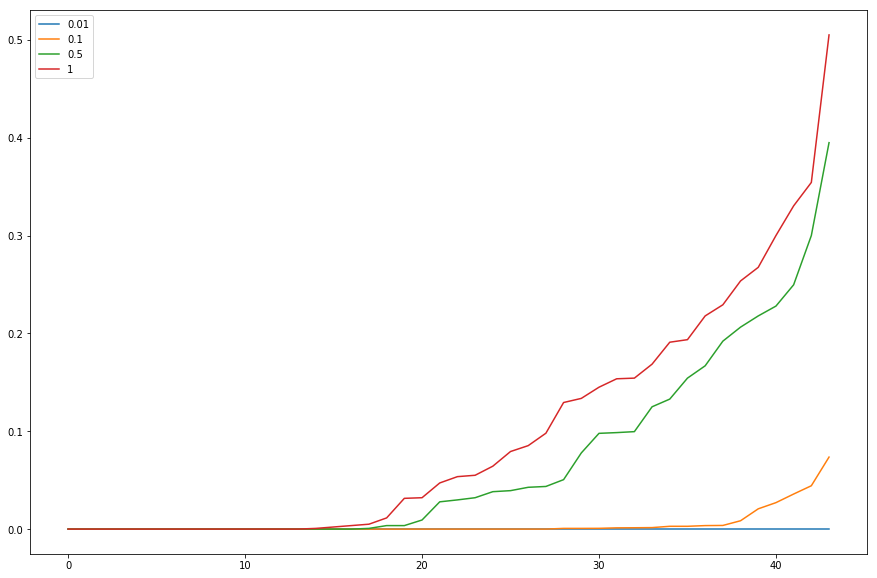

In [20]:
plt.figure(figsize=(15,10))
plt.plot(sorted(np.min(success_ratio_001, axis=1)), label="0.01")
plt.plot(sorted(np.min(success_ratio_01, axis=1)), label="0.1")
plt.plot(sorted(np.min(success_ratio_05, axis=1)), label="0.5")
plt.plot(sorted(np.min(success_ratio_1, axis=1)), label="1")
plt.legend()
plt.show()

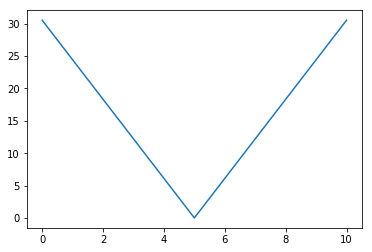

In [21]:
# Multiplikativní konstanta pro chybu ve scale
# Spočteno jako průměrná chyba přes všechny pixely
scale = []
for scx in np.arange(0.90, 1.1, 0.02):
    scy = scx
    X, Y = np.meshgrid(range(0, 400),range(0, 400))
    scale.append(np.sum(np.sqrt(np.power(X * scx - X, 2) + np.power(Y * scy - Y, 2))) / 160000)
    
plt.plot(scale)
plt.show()

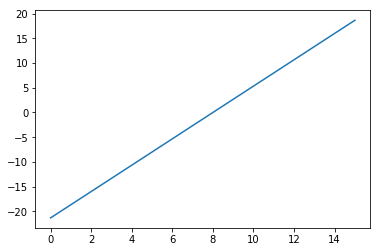

In [22]:
# Multiplikativní konstanta pro chybu ve scale
# Spočteno jako průměrná chyba přes všechny pixely
rotation = []
for angle in np.arange(-4, 4, 0.5):
    X, Y = np.meshgrid(range(0, 400),range(0, 400))
    rotation.append(np.sum(2 * np.sqrt(np.power(X, 2) + np.power(Y, 2)) * np.sin(angle / 2 / 180 * np.pi))/160000)
    
plt.plot(rotation)
plt.show()

In [23]:
import cv2

def tt1(params):
    [x_shift, y_shift, rot, x_sc, y_sc, xe, ye, rote, x_sc_e, y_sc_e] = params
    rt = np.concatenate([cv2.getRotationMatrix2D((0,0), rot, 1), np.array([[0,0,1]])])    
    rt1 = np.concatenate([cv2.getRotationMatrix2D((0,0), -rote, 1), np.array([[0,0,1]])])    
    ss = np.array([[x_sc, 0, x_shift],[0, y_sc, y_shift],[0, 0, 1]])    
    ss1 = np.array([[x_sc_e, 0, -xe],[0, y_sc_e, -ye],[0, 0, 1]])    
    return np.matmul(np.matmul(rt, ss), np.matmul(rt1,ss1))

In [24]:
def px_pos_diff(tt1):
    X, Y = np.meshgrid(range(0, 400),range(0, 400))
    coords = np.stack([X, Y, np.ones(X.shape)])    
    x = coords[0, :, :] * tt1[0,0] + coords[1, :, :] * tt1[0,1] + coords[2, :,:] * tt1[0,2]
    y = coords[0, :,:] * tt1[1,0] + coords[1, :,:] * tt1[1,1] + coords[2, :,:] * tt1[1,2]   
    distance = np.sqrt(np.power(x,2) + np.power(y,2))
#     plt.imshow(distance, cmap='gray')
#     plt.show()
    focus = np.unravel_index(np.argmin(distance, axis=None), (400,400))    
#     print(distance[0,0])
    return distance[focus], focus

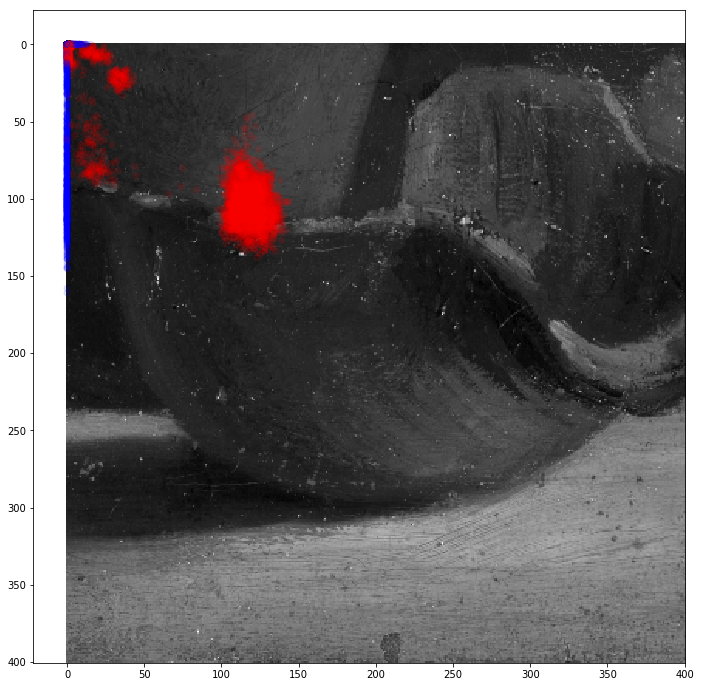

In [25]:
s1d = []
s1f = []
sample = 18
for i in df[df["sample"]==sample].index:
    tform = tt1(df[df["sample"]==sample].loc[i:i, ["x_shift", "y_shift", "rotation", "x_scale", "y_scale", "x_est", "y_est", "rot_est", "x_sc_est", "y_sc_est"]].to_numpy()[0])
    distance, focus = px_pos_diff(tform)
    s1d.append(distance)
    s1f.append(focus)
gray = cv2.imread(f"data/figures/sample_{sample}.png", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,12))
plt.imshow(gray, cmap='gray')
plt.scatter([point[1] for point in s1f], [point[0] for point in s1f], alpha=0.1, 
            color=["red" if point<2 else "blue" for point in s1d])
plt.show()